# Credit Risk Analysis

Credit risk analysis is a form of analysis performed by a credit analyst on potential borrowers to determine their ability to meet debt obligations. The main goal of credit analysis is to determine the creditworthiness of potential borrowers and their ability to honor their debt obligations.

If the borrower presents an acceptable level of default risk, the analyst can recommend the approval of the credit application at the agreed terms. The outcome of the credit risk analysis determines the risk rating that the borrower will be assigned and their ability to access credit.

The main purpose of credit risk analysis is to quantify the level of credit risk that the borrower presents to the lender. It involves assigning measurable numbers to the estimated probability of default of the borrower.

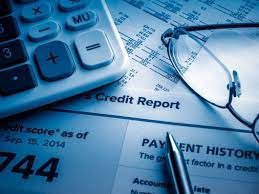

### IMPORTING LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

### LOADING THE DATASET

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


### SPLITTING THE DATA INTO TRAINING DATA AND TESTING DATA

In [5]:
# Create our features
# Convert string columns to numbers and drop 'loan_status' column then assign to X
X = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 
                'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 
                'debt_settlement_flag']).drop('loan_status', axis=1)

# Create our target
y = df['loan_status']
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [7]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
# Check balances
print(Counter(y_train))
print(Counter(y_test))

Counter({'low_risk': 51352, 'high_risk': 260})
Counter({'low_risk': 17118, 'high_risk': 87})


# ENSEMBLE LEARNING

### BALANCED RANDOM FOREST CLASSIFIER 

In [9]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
# Instantiate
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [10]:
# Calculated the balanced accuracy score
y_pred = brfc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7877672625306695

In [11]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,58,29
Actual low_risk,1560,15558


In [12]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.91      0.07      0.78      0.59        87
   low_risk       1.00      0.91      0.67      0.95      0.78      0.62     17118

avg / total       0.99      0.91      0.67      0.95      0.78      0.62     17205



The balanced accuracy score improved to about 78%.
The high_risk precision is still low at 4% only with 67% sensitivity which makes a F1 of only 7%.
Due to a lower number of false positives, the low_risk sensitivity is now 91% with 100% presicion.

### EASY ENSEMBLE ADABOOST CLASSIFIER

In [13]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
# Instantiate
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)

# Fit
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [14]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.925427358175101

In [15]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,79,8
Actual low_risk,979,16139


In [16]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205



Now, the balanced accuracy score is high to about 93%.
The high_risk precision is still low at 7% only with 91% sensitivity which makes a F1 of only 14%.
Due to a lower number of false positives, the low_risk sensitivity is now 94% with 100% presicion.

# OVERSAMPLING

### NAIVE RANDOM OVERSAMPLING

In [17]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
# Instantiate the model
ros = RandomOverSampler(random_state=1)
# Resample the targets
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [18]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state=1)

# Fit
logreg.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [19]:
# Calculate predictions
y_pred = logreg.predict(X_test)
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.6166366518808595

In [20]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,49,38
Actual low_risk,5648,11470


In [21]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.56      0.67      0.02      0.61      0.37        87
   low_risk       1.00      0.67      0.56      0.80      0.61      0.38     17118

avg / total       0.99      0.67      0.56      0.80      0.61      0.38     17205



The balanced accuracy score is 61%.
The high_risk precision is about 1% only with 56% sensitivity which makes a F1 of 2% only.
Due to the high number of the low_risk population, its precision is almost 100% with a sensitivity of 67%.

### SMOTE OVERSAMPLING 

In [22]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
# Instantiate the model
smote = SMOTE(random_state=1)
# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [23]:
# Train the Logistic Regression model using the resampled data
logreg.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [24]:
# Calculated the balanced accuracy score
y_pred = logreg.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6439490997578673

In [25]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,57,30
Actual low_risk,6287,10831


In [26]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.66      0.63      0.02      0.64      0.42        87
   low_risk       1.00      0.63      0.66      0.77      0.64      0.41     17118

avg / total       0.99      0.63      0.66      0.77      0.64      0.41     17205



The results are pretty similar to the previous model.
The balanced accuracy score is 64%.
The high_risk precision is about 1% only with 63% sensitivity which makes a F1 of 2% only.
Due to the high number of the low_risk population, its precision is almost 100% with a sensitivity of 66%.

# UNDERSAMPLING

### CLUSTER CENTROIDS MODEL

In [27]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
# Instantiate
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 260, 'low_risk': 260})

In [28]:
# Train the Logistic Regression model using the resampled data
logreg.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [29]:
# Calculated the balanced accuracy score
y_pred = logreg.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5295655712277054

In [30]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,53,34
Actual low_risk,9416,7702


In [31]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.61      0.45      0.01      0.52      0.28        87
   low_risk       1.00      0.45      0.61      0.62      0.52      0.27     17118

avg / total       0.99      0.45      0.61      0.62      0.52      0.27     17205



Here the balanced accuracy score is down to about 52%.
The high_risk precision is still 1% only with 61% sensitivity which makes a F1 of 1%.
Due to the high number of false positives, the low_risk sensitivity is only 40%.

# COMBINATION (OVER AND UNDER) SAMPLING

### SMOTEENN MODEL

In [32]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51351, 'low_risk': 46389})

In [33]:
# Train the Logistic Regression model using the resampled data
logreg.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [34]:
# Calculated the balanced accuracy score
y_pred = logreg.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6069704807603209

In [35]:
# Display the confusion matrix
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high_risk", "Actual low_risk"], columns=["Predicted high_risk", "Predicted low_risk"])
cm_df

,Predicted high_risk,Predicted low_risk
Actual high_risk,57,30
Actual low_risk,7553,9565


In [36]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.66      0.56      0.01      0.61      0.37        87
   low_risk       1.00      0.56      0.66      0.72      0.61      0.36     17118

avg / total       0.99      0.56      0.65      0.71      0.61      0.36     17205



The balanced accuracy score is about 61%.
The high_risk precision is still 1% only with 66% sensitivity which makes a F1 of only 2%.
Due to the high number of false positives, the low_risk sensitivity is 56%.

All the models used to perform the credit risk analysis show weak precision in determining if a credit risk is high.
The Ensemble models brought a lot more improvment specially on the sensitivity of the high risk credits.
The EasyEnsembleClassifier model shows a recall of 92% so it detects almost all high risk credit. On another hand, with a low precision, a lot of low risk credits are still falsely detected as high risk which would penalize the bank's credit strategy and infer on its revenue by missing those business opportunities.
For those reasons I would not recommend the bank to use any of these models to predict credit risk.